In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
CSV_PATH = "StudentsPerformance.csv"
PASS_THRESHOLD = 60.0   
RANDOM_STATE = 42       

df = pd.read_csv(CSV_PATH)


def find_col(df, includes_all=None, includes_any=None):
    cols = list(df.columns); lower = {c: c.lower() for c in cols}
    if includes_all:
        inc = [s.lower() for s in includes_all]
        for c in cols:
            if all(s in lower[c] for s in inc): return c
    if includes_any:
        inc = [s.lower() for s in includes_any]
        for c in cols:
            if any(s in lower[c] for s in inc): return c
    return None

def cohen_d(a, b):
    a = pd.Series(a).dropna().values
    b = pd.Series(b).dropna().values
    if len(a) < 2 or len(b) < 2: return np.nan
    pooled = np.sqrt(((a.size-1)*a.std(ddof=1)**2 + (b.size-1)*b.std(ddof=1)**2) / (a.size+b.size-2))
    return 0.0 if pooled == 0 else (a.mean() - b.mean()) / pooled

def r_squared(x, y):
    z = pd.concat([pd.Series(x), pd.Series(y)], axis=1).dropna()
    if len(z) < 2: return np.nan
    r = np.corrcoef(z.iloc[:,0], z.iloc[:,1])[0,1]
    return float(r**2)


gender_col   = find_col(df, includes_any=["gender"])
race_col     = find_col(df, includes_any=["race", "ethnicity"])
parent_col   = find_col(df, includes_all=["parental", "education"]) or find_col(df, includes_any=["parent"])
lunch_col    = find_col(df, includes_any=["lunch"])
testprep_col = find_col(df, includes_all=["test", "prepar"]) or find_col(df, includes_any=["prep"])

math_col     = find_col(df, includes_any=["math"])
reading_col  = find_col(df, includes_any=["reading"])
writing_col  = find_col(df, includes_any=["writing"])

score_cols = [c for c in [math_col, reading_col, writing_col] if c is not None]
if len(score_cols) >= 2 and "average_score" not in df.columns:
    df["average_score"] = df[score_cols].mean(axis=1)

print("Loaded:", df.shape, "\nColumns:", list(df.columns))


Loaded: (1000, 9) 
Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score', 'average_score']


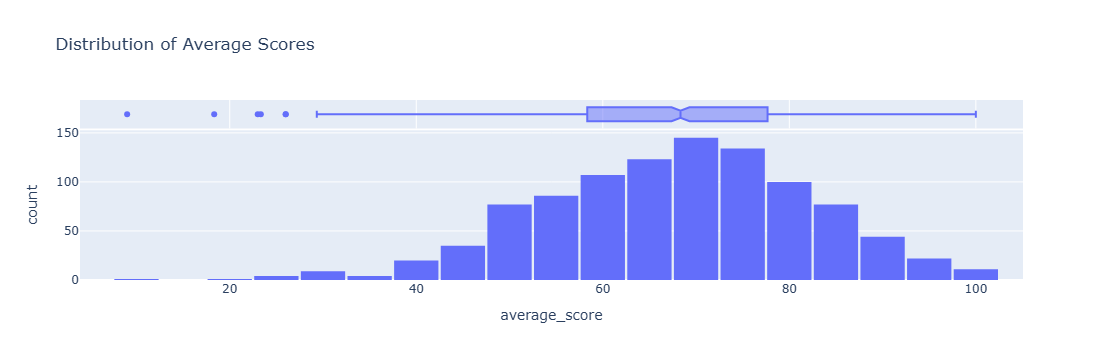

[INSIGHT] Mean=67.8, Median=68.3, SD=14.3, Skew=-0.30 → roughly symmetric.
[DECISION] If mean < your target (e.g., 70), consider tutoring, study groups, or curriculum review.


In [4]:
assert "average_score" in df.columns, "average_score not found; check score columns."

fig = px.histogram(df, x="average_score", nbins=20, title="Distribution of Average Scores", marginal="box")
fig.update_layout(bargap=0.05)
fig.show()

avg, med, sd, sk = df["average_score"].mean(), df["average_score"].median(), df["average_score"].std(), df["average_score"].skew()
skew_text = "roughly symmetric"
if sk > 0.5: skew_text = "right-skewed (longer high-score tail)"
elif sk < -0.5: skew_text = "left-skewed (longer low-score tail)"
print(f"[INSIGHT] Mean={avg:.1f}, Median={med:.1f}, SD={sd:.1f}, Skew={sk:.2f} → {skew_text}.")
print("[DECISION] If mean < your target (e.g., 70), consider tutoring, study groups, or curriculum review.")


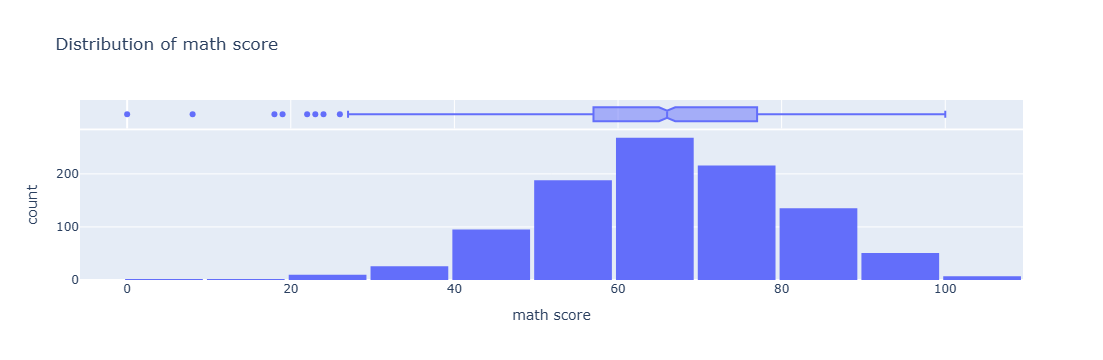

[INSIGHT] math score: Mean=66.1, Median=66.0, SD=15.2, Skew=-0.28.
[DECISION] If Math lags others, allocate more practice/review time to Math fundamentals.


In [5]:
assert math_col is not None
fig = px.histogram(df, x=math_col, nbins=20, title=f"Distribution of {math_col}", marginal="box")
fig.update_layout(bargap=0.05)
fig.show()

m, md, sd, sk = df[math_col].mean(), df[math_col].median(), df[math_col].std(), df[math_col].skew()
print(f"[INSIGHT] {math_col}: Mean={m:.1f}, Median={md:.1f}, SD={sd:.1f}, Skew={sk:.2f}.")
print("[DECISION] If Math lags others, allocate more practice/review time to Math fundamentals.")


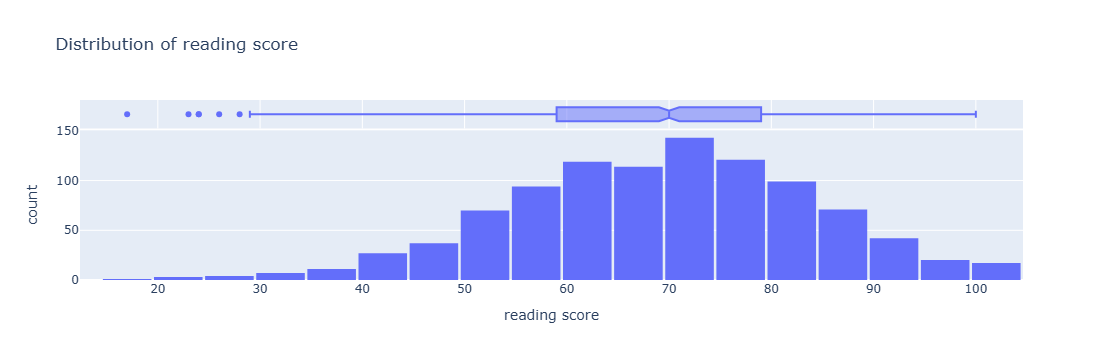

[INSIGHT] reading score: Mean=69.2, Median=70.0, SD=14.6, Skew=-0.26.
[DECISION] If Reading is weaker, emphasize comprehension strategies and practice sets.


In [6]:
assert reading_col is not None
fig = px.histogram(df, x=reading_col, nbins=20, title=f"Distribution of {reading_col}", marginal="box")
fig.update_layout(bargap=0.05)
fig.show()

m, md, sd, sk = df[reading_col].mean(), df[reading_col].median(), df[reading_col].std(), df[reading_col].skew()
print(f"[INSIGHT] {reading_col}: Mean={m:.1f}, Median={md:.1f}, SD={sd:.1f}, Skew={sk:.2f}.")
print("[DECISION] If Reading is weaker, emphasize comprehension strategies and practice sets.")


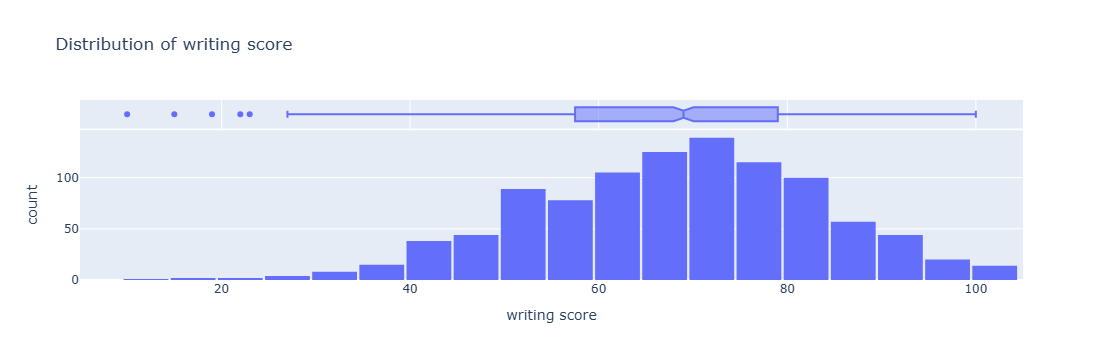

[INSIGHT] writing score: Mean=68.1, Median=69.0, SD=15.2, Skew=-0.29.
[DECISION] If Writing trails, add targeted writing drills and feedback cycles.


In [7]:
assert writing_col is not None
fig = px.histogram(df, x=writing_col, nbins=20, title=f"Distribution of {writing_col}", marginal="box")
fig.update_layout(bargap=0.05)
fig.show()

m, md, sd, sk = df[writing_col].mean(), df[writing_col].median(), df[writing_col].std(), df[writing_col].skew()
print(f"[INSIGHT] {writing_col}: Mean={m:.1f}, Median={md:.1f}, SD={sd:.1f}, Skew={sk:.2f}.")
print("[DECISION] If Writing trails, add targeted writing drills and feedback cycles.")


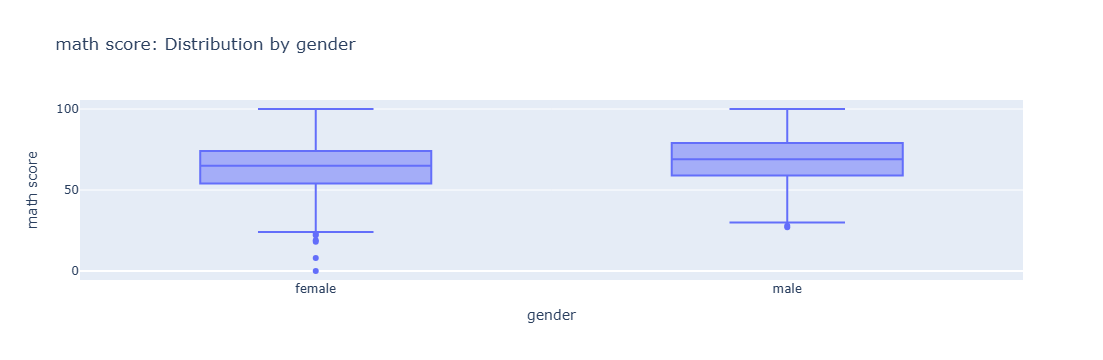

[INSIGHT] math score medians by gender: {'female': 65.0, 'male': 69.0}
[DECISION] Address groups with lower medians via focused support or resources.


In [8]:
assert gender_col is not None and math_col is not None
fig = px.box(df, x=gender_col, y=math_col, points="outliers", title=f"{math_col}: Distribution by {gender_col}")
fig.show()

meds = df.groupby(gender_col)[math_col].median().round(1).to_dict()
print(f"[INSIGHT] {math_col} medians by {gender_col}: {meds}")
print("[DECISION] Address groups with lower medians via focused support or resources.")


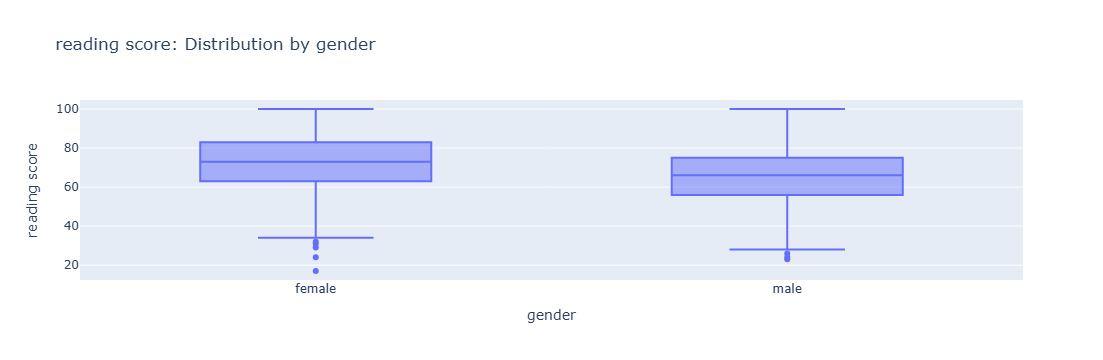

[INSIGHT] reading score medians by gender: {'female': 73.0, 'male': 66.0}
[DECISION] Consider differentiated reading strategies for the lower-median group.


In [9]:
assert gender_col is not None and reading_col is not None
fig = px.box(df, x=gender_col, y=reading_col, points="outliers", title=f"{reading_col}: Distribution by {gender_col}")
fig.show()

meds = df.groupby(gender_col)[reading_col].median().round(1).to_dict()
print(f"[INSIGHT] {reading_col} medians by {gender_col}: {meds}")
print("[DECISION] Consider differentiated reading strategies for the lower-median group.")


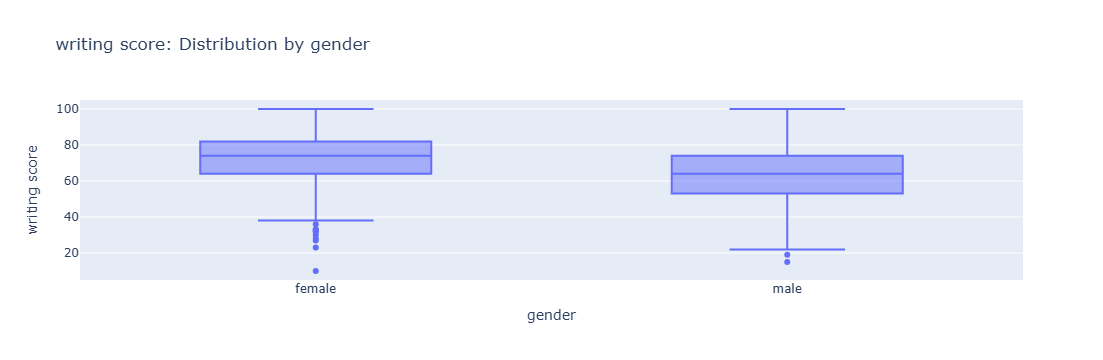

[INSIGHT] writing score medians by gender: {'female': 74.0, 'male': 64.0}
[DECISION] More guided writing practice if one group lags.


In [10]:
assert gender_col is not None and writing_col is not None
fig = px.box(df, x=gender_col, y=writing_col, points="outliers", title=f"{writing_col}: Distribution by {gender_col}")
fig.show()

meds = df.groupby(gender_col)[writing_col].median().round(1).to_dict()
print(f"[INSIGHT] {writing_col} medians by {gender_col}: {meds}")
print("[DECISION] More guided writing practice if one group lags.")


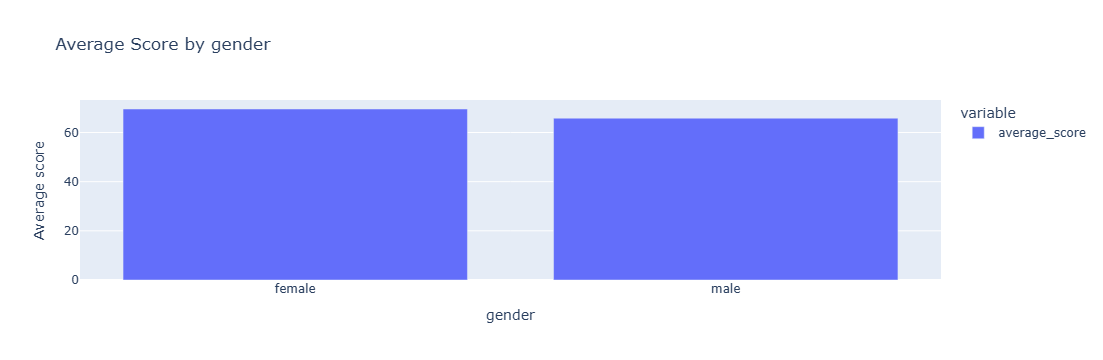

[INSIGHT] Highest: female (69.6); Lowest: male (65.8); Gap=3.7.
[DECISION] Investigate drivers of the gap (study time, resources, environment).


In [11]:
assert gender_col is not None and "average_score" in df.columns
grp = df.groupby(gender_col)["average_score"].mean().sort_values(ascending=False)

fig = px.bar(grp, title=f"Average Score by {gender_col}", labels={"value":"Average score", "index":gender_col})
fig.show()

gap = grp.iloc[0] - grp.iloc[-1]
print(f"[INSIGHT] Highest: {grp.index[0]} ({grp.iloc[0]:.1f}); Lowest: {grp.index[-1]} ({grp.iloc[-1]:.1f}); Gap={gap:.1f}.")
print("[DECISION] Investigate drivers of the gap (study time, resources, environment).")


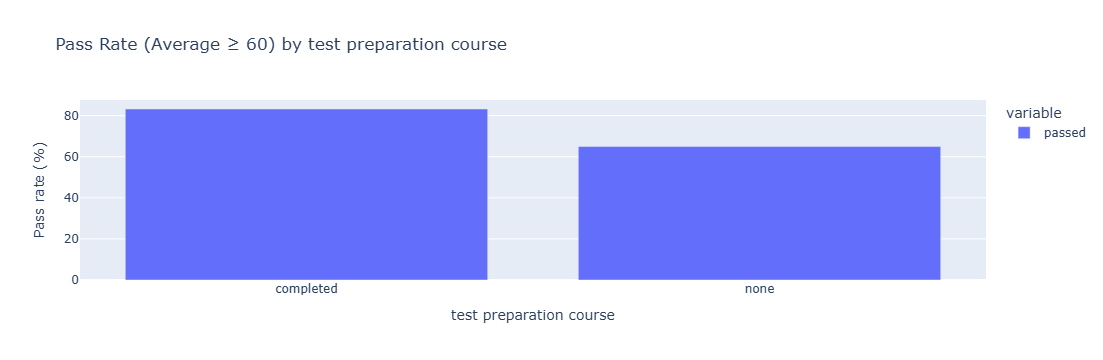

[INSIGHT] Best: completed at 83.2% vs none at 65.0% (Δ≈18.3 pp).
[DECISION] If Δ is sizeable, scale or refine the preparation program.


In [12]:
assert testprep_col is not None and "average_score" in df.columns
passed = (df["average_score"] >= PASS_THRESHOLD).astype(int)
rate = df.assign(passed=passed).groupby(testprep_col)["passed"].mean().sort_values(ascending=False)

fig = px.bar(rate*100, title=f"Pass Rate (Average ≥ {PASS_THRESHOLD:g}) by {testprep_col}",
             labels={"value":"Pass rate (%)", "index":testprep_col})
fig.show()

delta_pp = (rate.iloc[0]-rate.iloc[-1])*100
print(f"[INSIGHT] Best: {rate.index[0]} at {rate.iloc[0]*100:.1f}% vs {rate.index[-1]} at {rate.iloc[-1]*100:.1f}% (Δ≈{delta_pp:.1f} pp).")
print("[DECISION] If Δ is sizeable, scale or refine the preparation program.")


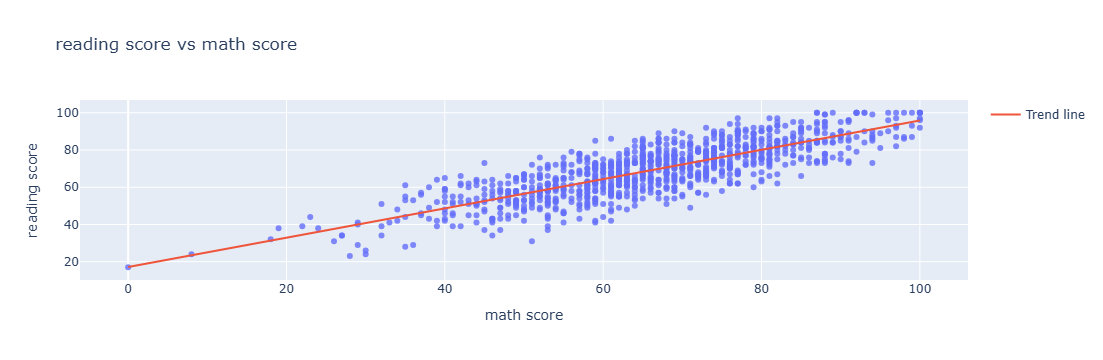

[INSIGHT] R² ≈ 0.67 (closer to 1 = stronger linear relation).
[DECISION] Strong linkage suggests cross-subject study strategies can transfer.


In [13]:
assert math_col and reading_col
xy = df[[math_col, reading_col]].dropna()
x = xy[math_col].values
y = xy[reading_col].values

# Base scatter
fig = px.scatter(xy, x=math_col, y=reading_col, opacity=0.8, title=f"{reading_col} vs {math_col}")

# Add simple linear fit (no extra dependency)
if len(x) >= 2:
    coeffs = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    ys = coeffs[0]*xs + coeffs[1]
    fig.add_trace(go.Scatter(x=xs, y=ys, mode="lines", name="Trend line"))

fig.show()

print(f"[INSIGHT] R² ≈ {r_squared(x, y):.2f} (closer to 1 = stronger linear relation).")
print("[DECISION] Strong linkage suggests cross-subject study strategies can transfer.")


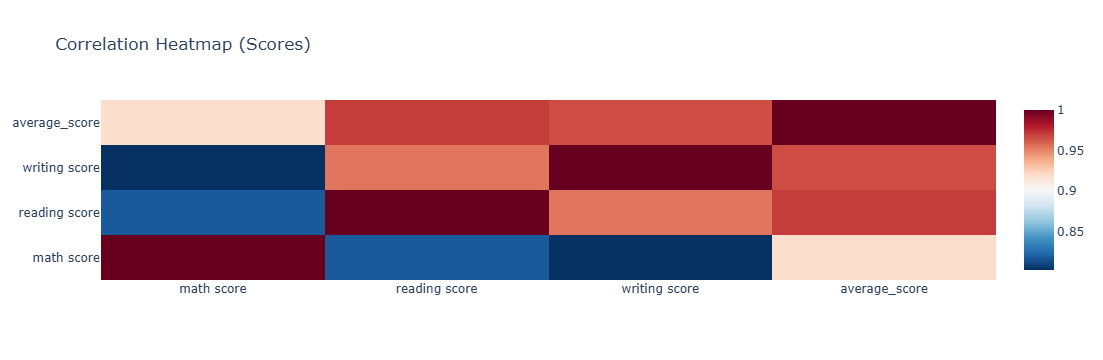

[INSIGHT] Strongest correlation: reading score ↔ average_score (r=0.97).
[DECISION] Highly correlated subjects can be taught with integrated concepts.


In [14]:
heat_cols = [c for c in score_cols if c is not None]
if "average_score" in df.columns: heat_cols.append("average_score")

corr = df[heat_cols].corr()
fig = go.Figure(data=go.Heatmap(
    z=corr.values, x=heat_cols, y=heat_cols, zauto=True,
    colorscale="RdBu", reversescale=True, zmin=-1, zmax=1
))
fig.update_layout(title="Correlation Heatmap (Scores)")
fig.show()

pairs = []
for i in range(len(heat_cols)):
    for j in range(i+1, len(heat_cols)):
        pairs.append((heat_cols[i], heat_cols[j], corr.iloc[i,j]))
pairs.sort(key=lambda t: abs(t[2]), reverse=True)
if pairs:
    a,b,r = pairs[0]
    print(f"[INSIGHT] Strongest correlation: {a} ↔ {b} (r={r:.2f}).")
print("[DECISION] Highly correlated subjects can be taught with integrated concepts.")


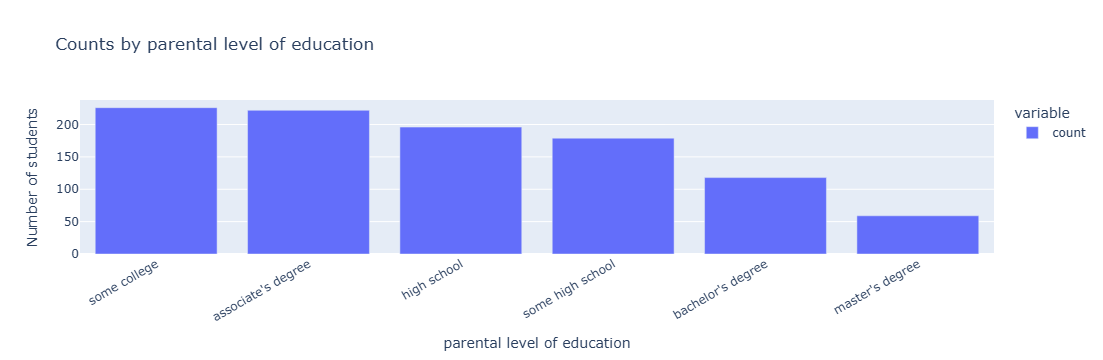

[INSIGHT] Top categories: {'some college': 226, "associate's degree": 222}
[DECISION] Keep composition in mind; differences in averages can reflect sample mix.


In [15]:
assert parent_col is not None
counts = df[parent_col].value_counts()

fig = px.bar(counts, title=f"Counts by {parent_col}",
             labels={"index": parent_col, "value": "Number of students"})
fig.update_layout(xaxis_tickangle=-30)
fig.show()

print(f"[INSIGHT] Top categories: {counts.head(2).to_dict()}")
print("[DECISION] Keep composition in mind; differences in averages can reflect sample mix.")


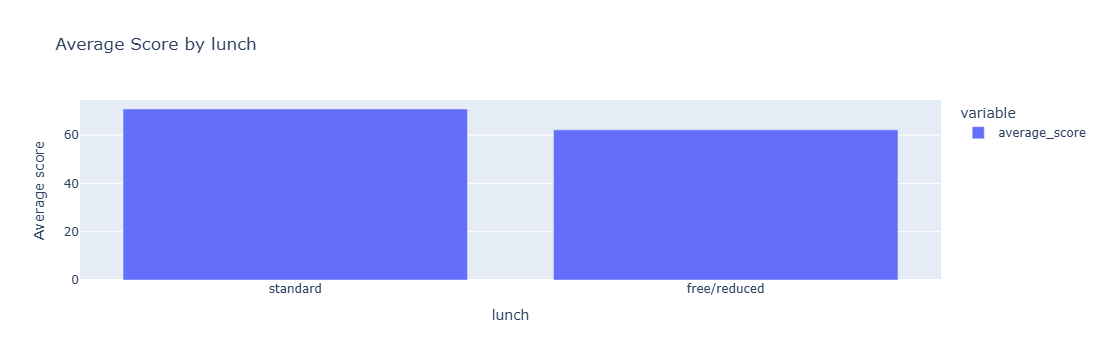

[INSIGHT] Highest ≈ 70.8, Lowest ≈ 62.2; Gap ≈ 8.6.
[DECISION] If reduced/free lunch tracks lower, consider nutrition or study-support programs.


In [16]:
assert lunch_col and "average_score" in df.columns
lunch_avg = df.groupby(lunch_col)["average_score"].mean().sort_values(ascending=False)

fig = px.bar(lunch_avg, title=f"Average Score by {lunch_col}",
             labels={"index": lunch_col, "value": "Average score"})
fig.show()

gap = float(lunch_avg.iloc[0] - lunch_avg.iloc[-1])
print(f"[INSIGHT] Highest ≈ {lunch_avg.iloc[0]:.1f}, Lowest ≈ {lunch_avg.iloc[-1]:.1f}; Gap ≈ {gap:.1f}.")
print("[DECISION] If reduced/free lunch tracks lower, consider nutrition or study-support programs.")


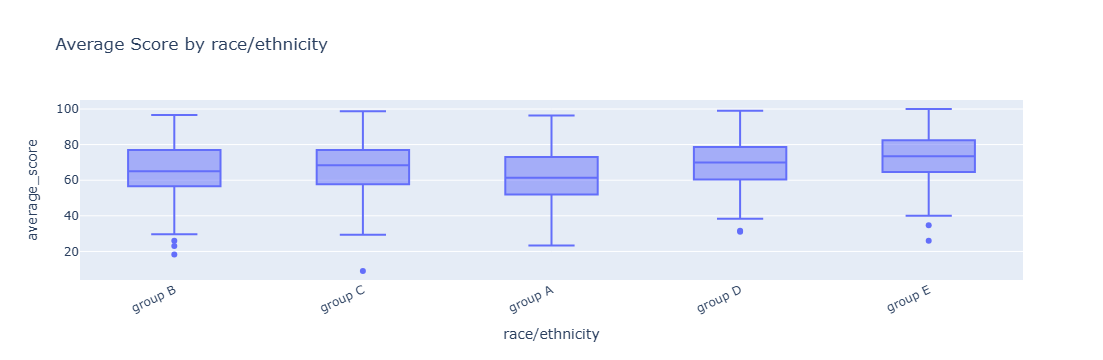

[INSIGHT] Medians by race/ethnicity: {'group A': 61.3, 'group B': 65.0, 'group C': 68.3, 'group D': 70.0, 'group E': 73.5}
[DECISION] Use medians when outliers exist; target supports to lower-median groups.


In [17]:
assert race_col and "average_score" in df.columns
fig = px.box(df, x=race_col, y="average_score", points="outliers",
             title=f"Average Score by {race_col}")
fig.update_layout(xaxis_tickangle=-25)
fig.show()

meds = df.groupby(race_col)["average_score"].median().round(1)
print(f"[INSIGHT] Medians by {race_col}: {meds.to_dict()}")
print("[DECISION] Use medians when outliers exist; target supports to lower-median groups.")


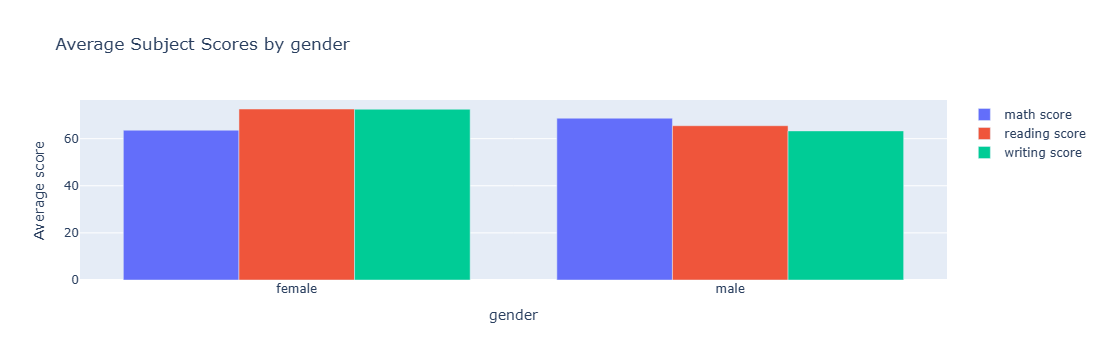

[INSIGHT] Gaps by subject: {'math score': 5.100000000000001, 'reading score': 7.099999999999994, 'writing score': 9.200000000000003}. Biggest gap in: writing score.
[DECISION] Focus interventions on the subject with the largest disparity.


In [18]:
assert gender_col and len(score_cols) >= 2
gb = df.groupby(gender_col)[score_cols].mean().round(1).reset_index()
fig = go.Figure()
for c in score_cols:
    fig.add_trace(go.Bar(x=gb[gender_col], y=gb[c], name=c))
fig.update_layout(barmode="group", title=f"Average Subject Scores by {gender_col}",
                  xaxis_title=gender_col, yaxis_title="Average score")
fig.show()

diffs = {c: float(gb[c].max() - gb[c].min()) for c in score_cols}
biggest = max(diffs, key=diffs.get)
print(f"[INSIGHT] Gaps by subject: {diffs}. Biggest gap in: {biggest}.")
print("[DECISION] Focus interventions on the subject with the largest disparity.")


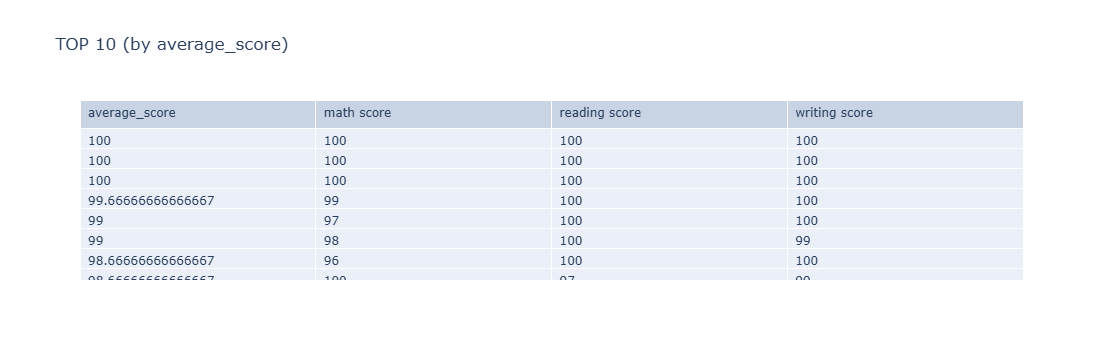

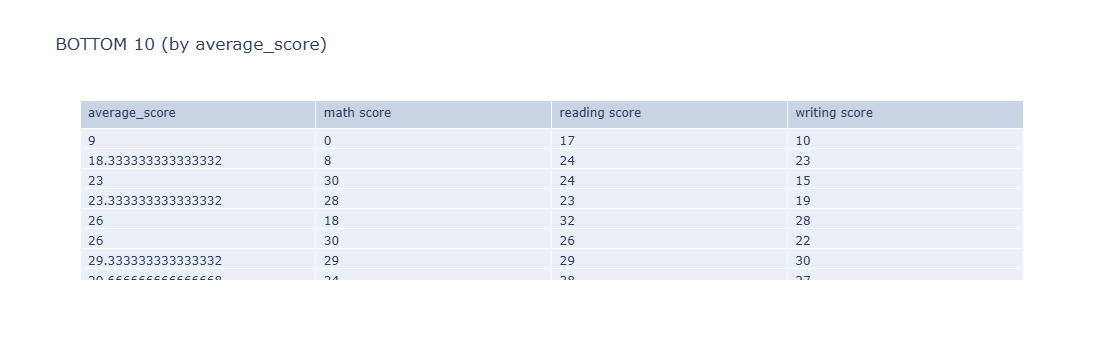

[DECISION] Study top habits/resources; provide targeted support to the bottom group.


In [24]:
import plotly.graph_objects as go

def show_table(df_, title):
    df_ = df_.reset_index(drop=True)
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_.columns), align="left"),
        cells=dict(values=[df_[c] for c in df_.columns], align="left")
    )])
    fig.update_layout(title=title)
    fig.show()

assert "average_score" in df.columns
top10 = df.nlargest(10, "average_score")[["average_score"] + score_cols]
bot10 = df.nsmallest(10, "average_score")[["average_score"] + score_cols]

show_table(top10, "TOP 10 (by average_score)")
show_table(bot10, "BOTTOM 10 (by average_score)")

print("[DECISION] Study top habits/resources; provide targeted support to the bottom group.")


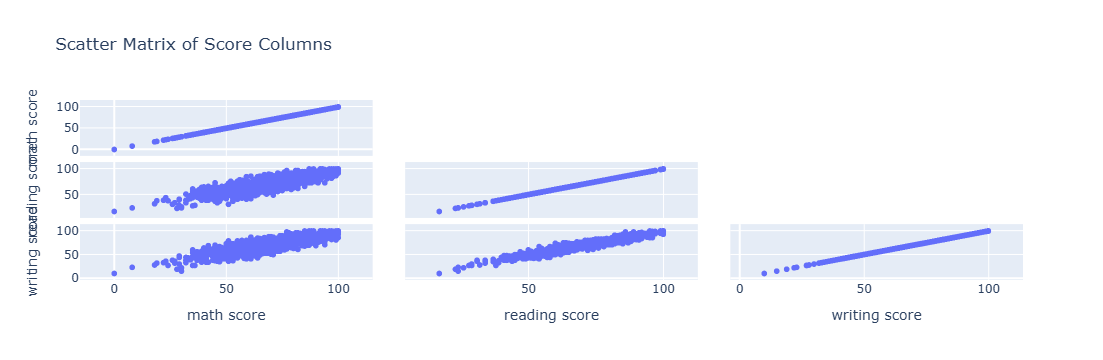

[INSIGHT] Diagonal = distributions; off-diagonal = relationships (linear/nonlinear).
[DECISION] Nonlinear clouds → consider nonlinear models if you later predict scores.


In [22]:
num_scores = df[score_cols].dropna()
if num_scores.shape[1] >= 2 and len(num_scores) > 0:
    fig = px.scatter_matrix(num_scores, dimensions=score_cols, title="Scatter Matrix of Score Columns")
    fig.update_traces(diagonal_visible=True, showupperhalf=False)
    fig.show()

    print("[INSIGHT] Diagonal = distributions; off-diagonal = relationships (linear/nonlinear).")
    print("[DECISION] Nonlinear clouds → consider nonlinear models if you later predict scores.")


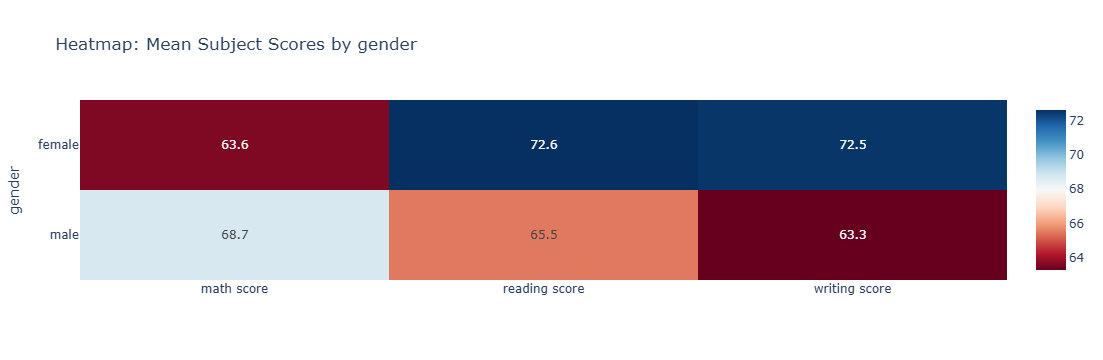

[INSIGHT] Table of means:
        math score  reading score  writing score
gender                                          
female        63.6           72.6           72.5
male          68.7           65.5           63.3
[DECISION] Darker cells highlight where a group excels or needs support.


In [25]:
assert gender_col and len(score_cols) >= 2
pivot = df.pivot_table(index=gender_col, values=score_cols, aggfunc="mean").round(1)
fig = px.imshow(pivot, text_auto=True, aspect="auto", color_continuous_scale="RdBu",
                title=f"Heatmap: Mean Subject Scores by {gender_col}")
fig.show()

print(f"[INSIGHT] Table of means:\n{pivot}")
print("[DECISION] Darker cells highlight where a group excels or needs support.")
